# Things to try

## Normalization
- [x] Normalize input.

## Optimizers
- [x] NAdam
- [x] RMSProp
- [x] Adam
- [x] Add scheduler

## Architecture
- [x] Baseline model
- [x] Increase neurons
- [x] Increase layers
- [x] ConvNet

## Regularization
- [x] Dropout layers

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Setup Problem

In [2]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig
    
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs
    
    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0) 
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch
    
    def __len__(self):
        return len(self.ebno_dbs)
        


In [3]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, 
                         Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)


# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)

In [4]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


# Model Testing and Selection

## Baseline model with different optimizers

- [x] Normalize input (will be default from now on)

In [5]:
class Simplemodel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [6]:
# Create model
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizers = [torch.optim.Adam(model.parameters()), torch.optim.NAdam(model.parameters()),
              torch.optim.Adagrad(model.parameters()), torch.optim.RMSprop(model.parameters())]

In [37]:
from tqdm.auto import tqdm

def training_loop(model, start_epoch, num_epochs, train_losses, val_losses, val_BERs, use_scheduler=False):
    model=model.to(device)

    train_losses = []
    val_losses = []
    val_BERs = []
    for epoch in range(start_epoch, num_epochs):
        total_loss = 0.0
        model.train()  # Set the model to training mode

        for index, data_batch in enumerate(tqdm(train_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            outputs = model(samples)  # forward pass 
            loss = loss_fn(outputs, labels) 
            loss.backward()  # backward pass
            optimizer.step()  # update the weights
            total_loss += loss.item()  # accumulate the loss
            optimizer.zero_grad()  # Zero the gradients
        
        if use_scheduler:
            scheduler.step()
        # Print average loss for the epoch
        average_loss = total_loss / len(train_loader)
    
        # Validation
        model.eval()  # Set the model to evaluation mode
        BER_batch=[]
        with torch.no_grad():
            for index, data_batch in enumerate(tqdm(val_loader)):
                batch = {k: v.to(device) for k, v in data_batch.items()}
                samples = batch['samples']
                labels = batch['labels']
                val_outputs = model(samples)
                val_loss = loss_fn(val_outputs, labels)
    
                # Convert probabilities to binary predictions (0 or 1)
                binary_predictions = torch.round(val_outputs)
    
                # Calculate Bit Error Rate (BER)
                error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
                error_rate = error_count / len(labels.flatten())  # Error rate calculation
                BER_batch.append(error_rate.item())
                
        # Save performance details
        train_losses.append(average_loss)
        val_losses.append(val_loss.item())
        BER_batch_mean=np.mean(BER_batch)
        val_BERs.append(BER_batch_mean)#(BER.item())
    
        # Print or log validation loss after each epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")
    return train_losses, val_losses, val_BERs

def save_model(model, model_name):
    # Save the final trained model
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }
    modelsave_path = os.path.join(trainoutput, model_name)
    torch.save(checkpoint, modelsave_path)

def plot_train_val_loss(train_losses, val_losses, name="test"):
    # Plot Training Loss and Validation Loss
    plt.figure(figsize=(7, 3))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.grid(True)
    plt.savefig(f"./graphs/{name}.pdf", format='pdf', bbox_inches='tight')

def plot_val_BER(val_BERs, name="test"):
    # Plot Validation BER
    plt.figure(figsize=(7, 3))
    plt.plot(val_BERs, label='Validation BER')
    plt.xlabel('Epochs')
    plt.ylabel('BER')
    plt.legend()
    plt.title('Bit Error Rate (BER) on validation set')
    plt.grid(True)
    plt.savefig(f"./graphs/{name}.pdf", format='pdf', bbox_inches='tight')

### Baseline with Adam

In [30]:
# Create model
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters())

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 326.47it/s]


Epoch [1/10], Loss: 0.6457, Val Loss: 0.7354, Val BER: 0.2941


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 322.49it/s]


Epoch [2/10], Loss: 0.6086, Val Loss: 0.6016, Val BER: 0.2238


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 323.08it/s]


Epoch [3/10], Loss: 0.5906, Val Loss: 0.5165, Val BER: 0.2265


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 331.27it/s]


Epoch [4/10], Loss: 0.5769, Val Loss: 0.7524, Val BER: 0.2089


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 349.99it/s]


Epoch [5/10], Loss: 0.5640, Val Loss: 0.4548, Val BER: 0.1969


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 361.53it/s]


Epoch [6/10], Loss: 0.5506, Val Loss: 0.4395, Val BER: 0.1913


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 329.62it/s]


Epoch [7/10], Loss: 0.5370, Val Loss: 0.6578, Val BER: 0.1861


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 327.82it/s]


Epoch [8/10], Loss: 0.5239, Val Loss: 0.3816, Val BER: 0.1848


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 345.70it/s]


Epoch [9/10], Loss: 0.5123, Val Loss: 0.6591, Val BER: 0.1844


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 356.75it/s]


Epoch [10/10], Loss: 0.5025, Val Loss: 0.3362, Val BER: 0.1843


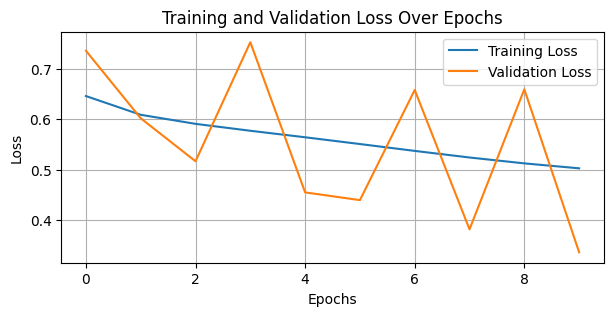

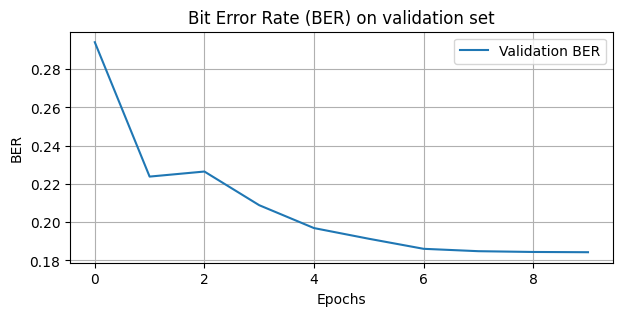

In [31]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs)

plot_train_val_loss(train_losses, val_losses, name="baseline_Adam_val")
plot_val_BER(val_BERs, name="baseline_Adam_BER")

**Comment**: Not bad not good. We do see some decrease in BER here.

### Baseline with NAdam

In [33]:
# Create model
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 397.66it/s]


Epoch [1/10], Loss: 0.6540, Val Loss: 0.5684, Val BER: 0.2133


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 315.93it/s]


Epoch [2/10], Loss: 0.5976, Val Loss: 0.5009, Val BER: 0.1948


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 339.57it/s]


Epoch [3/10], Loss: 0.5712, Val Loss: 0.4686, Val BER: 0.1941


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 364.70it/s]


Epoch [4/10], Loss: 0.5470, Val Loss: 0.7325, Val BER: 0.1887


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 335.21it/s]


Epoch [5/10], Loss: 0.5254, Val Loss: 0.4165, Val BER: 0.1868


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 326.89it/s]


Epoch [6/10], Loss: 0.5071, Val Loss: 0.5313, Val BER: 0.1855


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 332.92it/s]


Epoch [7/10], Loss: 0.4920, Val Loss: 0.3062, Val BER: 0.1854


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 326.45it/s]


Epoch [8/10], Loss: 0.4802, Val Loss: 0.2848, Val BER: 0.1850


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 329.87it/s]


Epoch [9/10], Loss: 0.4713, Val Loss: 0.3977, Val BER: 0.1852


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 326.44it/s]


Epoch [10/10], Loss: 0.4648, Val Loss: 0.2870, Val BER: 0.1847


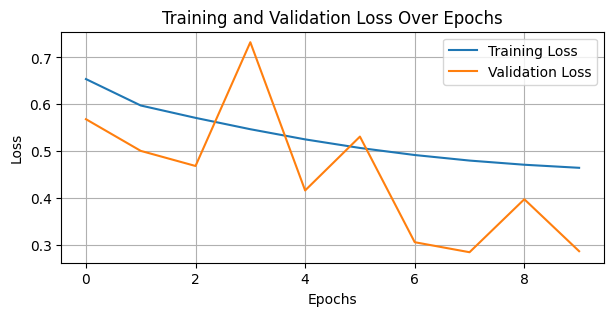

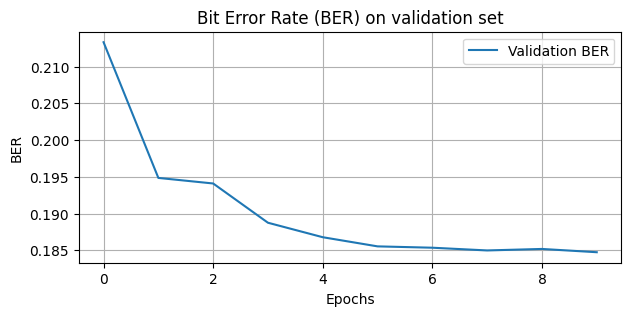

In [34]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs)

plot_train_val_loss(train_losses, val_losses, name="baseline_NAdam_val")
plot_val_BER(val_BERs, name="baseline_NAdam_BER")

**Comment**: This model is more stable on the train val loss than Adam.

### Baseline with RMSProp

In [50]:
# Create model
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.RMSprop(model.parameters())

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 325.97it/s]


Epoch [1/10], Loss: 0.5344, Val Loss: 0.4695, Val BER: 0.1882


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 314.08it/s]


Epoch [2/10], Loss: 0.4774, Val Loss: 0.8318, Val BER: 0.1852


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 322.64it/s]


Epoch [3/10], Loss: 0.4622, Val Loss: 0.8031, Val BER: 0.1865


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 331.87it/s]


Epoch [4/10], Loss: 0.4556, Val Loss: 0.1869, Val BER: 0.1849


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 324.01it/s]


Epoch [5/10], Loss: 0.4503, Val Loss: 0.8103, Val BER: 0.1879


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 400.76it/s]


Epoch [6/10], Loss: 0.4492, Val Loss: 0.7996, Val BER: 0.1855


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 313.44it/s]


Epoch [7/10], Loss: 0.4473, Val Loss: 0.6502, Val BER: 0.1861


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 350.03it/s]


Epoch [8/10], Loss: 0.4455, Val Loss: 0.2467, Val BER: 0.1863


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.76it/s]


Epoch [9/10], Loss: 0.4445, Val Loss: 0.1628, Val BER: 0.1865


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 341.82it/s]


Epoch [10/10], Loss: 0.4447, Val Loss: 0.5275, Val BER: 0.1856


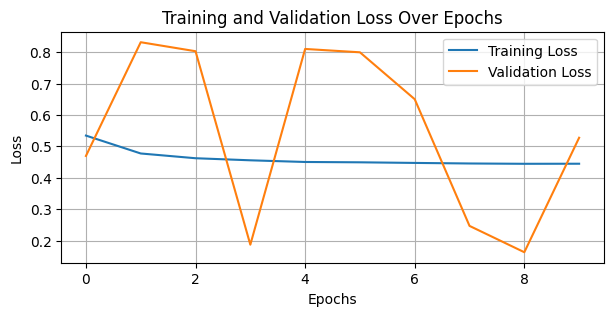

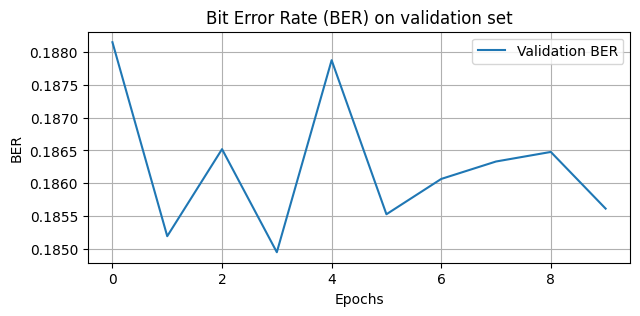

In [51]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs)

plot_train_val_loss(train_losses, val_losses, name="baseline_RMSProp_val")
plot_val_BER(val_BERs, name="baseline_RMSProp_BER")

**Comment**: This looks slightly worse than NAdam. Out of the 3 optmizers, NAdam is the most stable of the bunch.

### Baseline with NAdam and scheduler

In [52]:
# Create model
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 328.08it/s]


Epoch [1/10], Loss: 0.6469, Val Loss: 0.6067, Val BER: 0.2074


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 365.11it/s]


Epoch [2/10], Loss: 0.5892, Val Loss: 0.5243, Val BER: 0.1958


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 359.67it/s]


Epoch [3/10], Loss: 0.5608, Val Loss: 0.6896, Val BER: 0.1881


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 334.66it/s]


Epoch [4/10], Loss: 0.5352, Val Loss: 0.3985, Val BER: 0.1844


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 321.08it/s]


Epoch [5/10], Loss: 0.5135, Val Loss: 0.3766, Val BER: 0.1843


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 332.37it/s]


Epoch [6/10], Loss: 0.4968, Val Loss: 0.4627, Val BER: 0.1837


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 323.15it/s]


Epoch [7/10], Loss: 0.4847, Val Loss: 0.2887, Val BER: 0.1841


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 394.98it/s]


Epoch [8/10], Loss: 0.4759, Val Loss: 0.7460, Val BER: 0.1844


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 332.73it/s]


Epoch [9/10], Loss: 0.4696, Val Loss: 0.4394, Val BER: 0.1848


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 332.13it/s]


Epoch [10/10], Loss: 0.4650, Val Loss: 0.4575, Val BER: 0.1846


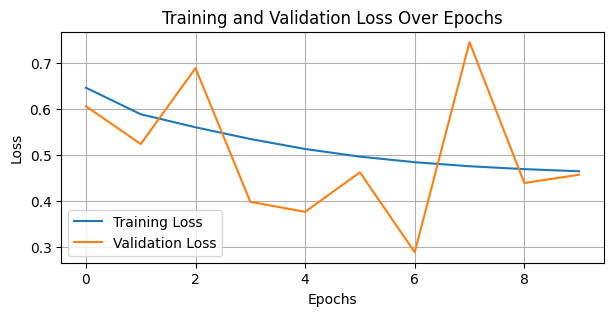

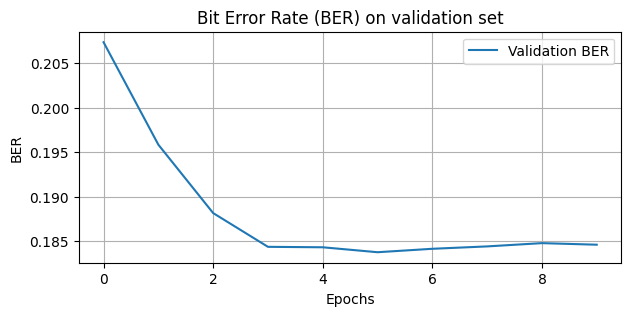

In [53]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="baseline_NAdam_scheduler_val")
plot_val_BER(val_BERs, name="baseline_NAdam_scheduler_BER")

**Comment**: The BER curve is smoother than before, which is good. We manage to keep validation loss below training loss for majority of epoch, which is also good. That's our scheduler kicking in.

Moving on, we will use NAdam with scheduler as our optimizer method of choice.

# Baseline model + Normalization layer + NAdam

Next, we will add a normalization layer into our simple model.

## Baseline normalized + NAdam

In [56]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [57]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 313.97it/s]


Epoch [1/10], Loss: 0.6770, Val Loss: 0.6338, Val BER: 0.2778


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 352.89it/s]


Epoch [2/10], Loss: 0.6199, Val Loss: 0.5584, Val BER: 0.2449


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 326.09it/s]


Epoch [3/10], Loss: 0.5766, Val Loss: 0.5493, Val BER: 0.2377


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 329.52it/s]


Epoch [4/10], Loss: 0.5534, Val Loss: 0.5071, Val BER: 0.2362


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 323.95it/s]


Epoch [5/10], Loss: 0.5407, Val Loss: 0.6389, Val BER: 0.2340


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 323.42it/s]


Epoch [6/10], Loss: 0.5325, Val Loss: 0.4525, Val BER: 0.2311


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 329.39it/s]


Epoch [7/10], Loss: 0.5265, Val Loss: 0.3974, Val BER: 0.2273


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 324.13it/s]


Epoch [8/10], Loss: 0.5218, Val Loss: 0.4663, Val BER: 0.2218


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 330.97it/s]


Epoch [9/10], Loss: 0.5174, Val Loss: 0.4454, Val BER: 0.2148


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 326.72it/s]


Epoch [10/10], Loss: 0.5126, Val Loss: 0.7884, Val BER: 0.2080


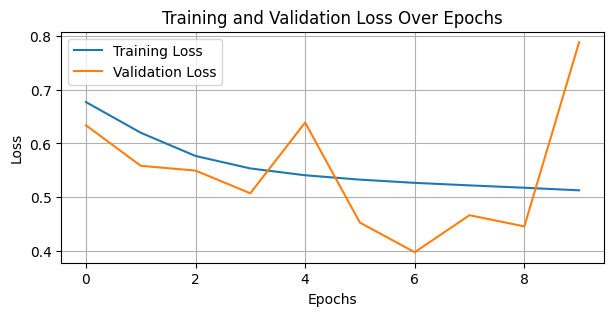

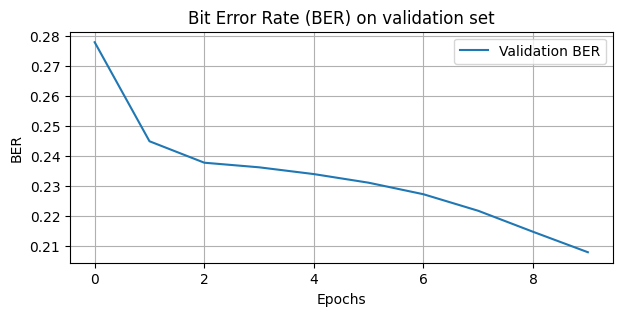

In [58]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="normalized_NAdam_scheduler_val")
plot_val_BER(val_BERs, name="normalized_NAdam_scheduler_BER")

**Comment**: this is almost the same as the previous iteration, except that the BER curve is extremely smooth. 

It also looks like that if we continue training, we will achieve a lower BER score.

# Normalized Simple Model with more Neurons

## 64 neurons

In [60]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=64)
        self.linear2=nn.Linear(in_features=64, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [61]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.33it/s]


Epoch [1/10], Loss: 0.6655, Val Loss: 0.6449, Val BER: 0.2613


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 338.09it/s]


Epoch [2/10], Loss: 0.5921, Val Loss: 0.5601, Val BER: 0.2479


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 328.62it/s]


Epoch [3/10], Loss: 0.5535, Val Loss: 0.4836, Val BER: 0.2295


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 327.73it/s]


Epoch [4/10], Loss: 0.5380, Val Loss: 0.7195, Val BER: 0.2262


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 314.58it/s]


Epoch [5/10], Loss: 0.5284, Val Loss: 0.4053, Val BER: 0.2185


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 311.64it/s]


Epoch [6/10], Loss: 0.5210, Val Loss: 0.3851, Val BER: 0.2074


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 330.75it/s]


Epoch [7/10], Loss: 0.5141, Val Loss: 0.3615, Val BER: 0.1997


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.80it/s]


Epoch [8/10], Loss: 0.5076, Val Loss: 0.3483, Val BER: 0.1915


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 340.52it/s]


Epoch [9/10], Loss: 0.5011, Val Loss: 0.3306, Val BER: 0.1882


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 329.03it/s]


Epoch [10/10], Loss: 0.4954, Val Loss: 0.7484, Val BER: 0.1862


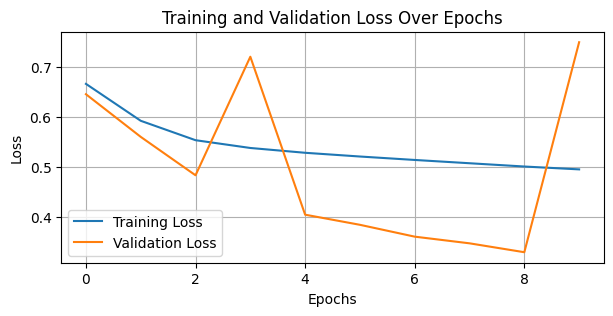

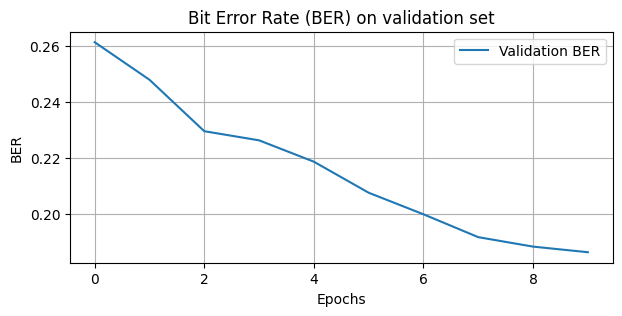

In [62]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="normalized_NAdam_scheduler_64n_val")
plot_val_BER(val_BERs, name="normalized_NAdam_scheduler_64n_BER")

**Comment**: We achieve better result with more neurons. 

Can we push it even further?

## 128 neurons

In [63]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=128)
        self.linear2=nn.Linear(in_features=128, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [64]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 357.36it/s]


Epoch [1/10], Loss: 0.6383, Val Loss: 0.5421, Val BER: 0.2314


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 341.80it/s]


Epoch [2/10], Loss: 0.5498, Val Loss: 0.4329, Val BER: 0.2062


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 368.34it/s]


Epoch [3/10], Loss: 0.5241, Val Loss: 0.5756, Val BER: 0.1928


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 338.59it/s]


Epoch [4/10], Loss: 0.5082, Val Loss: 0.3551, Val BER: 0.1848


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 365.92it/s]


Epoch [5/10], Loss: 0.4938, Val Loss: 0.3107, Val BER: 0.1825


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 356.41it/s]


Epoch [6/10], Loss: 0.4830, Val Loss: 0.8192, Val BER: 0.1820


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 364.23it/s]


Epoch [7/10], Loss: 0.4757, Val Loss: 0.3883, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 348.20it/s]


Epoch [8/10], Loss: 0.4711, Val Loss: 0.5516, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.00it/s]


Epoch [9/10], Loss: 0.4681, Val Loss: 0.2532, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 315.66it/s]


Epoch [10/10], Loss: 0.4662, Val Loss: 0.2391, Val BER: 0.1818


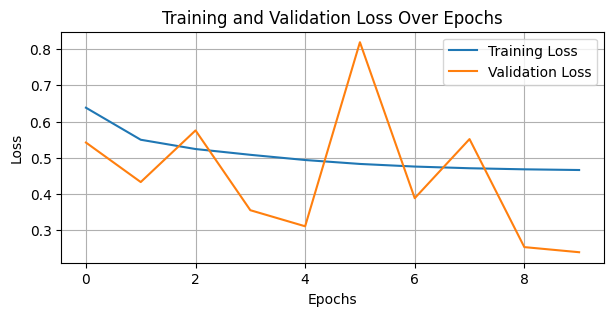

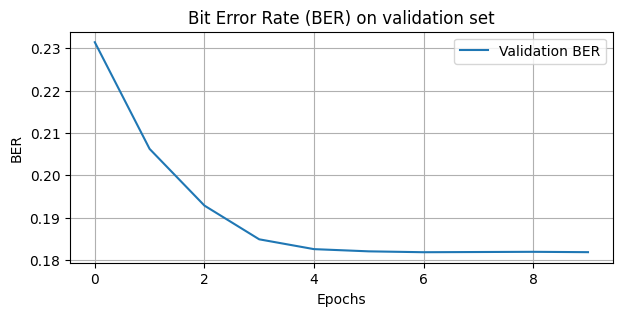

In [65]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="normalized_NAdam_scheduler_128n_val")
plot_val_BER(val_BERs, name="normalized_NAdam_scheduler_128n_BER")

**Comment**: That's an even better BER curve. Decreasing smooth like butter, but it feels like it hits the bottom.
Can we be even more expressive?

## 256 neurons

In [67]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=256)
        self.linear2=nn.Linear(in_features=256, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [68]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 357.19it/s]


Epoch [1/10], Loss: 0.5689, Val Loss: 0.4287, Val BER: 0.2197


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 347.82it/s]


Epoch [2/10], Loss: 0.5176, Val Loss: 0.6002, Val BER: 0.1916


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 349.57it/s]


Epoch [3/10], Loss: 0.4970, Val Loss: 0.3360, Val BER: 0.1829


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 353.34it/s]


Epoch [4/10], Loss: 0.4823, Val Loss: 0.6507, Val BER: 0.1820


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 355.46it/s]


Epoch [5/10], Loss: 0.4736, Val Loss: 0.2527, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 345.98it/s]


Epoch [6/10], Loss: 0.4686, Val Loss: 0.8043, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 351.70it/s]


Epoch [7/10], Loss: 0.4658, Val Loss: 0.2958, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 352.20it/s]


Epoch [8/10], Loss: 0.4641, Val Loss: 0.7035, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 349.44it/s]


Epoch [9/10], Loss: 0.4627, Val Loss: 0.8728, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 345.36it/s]


Epoch [10/10], Loss: 0.4617, Val Loss: 0.2096, Val BER: 0.1818


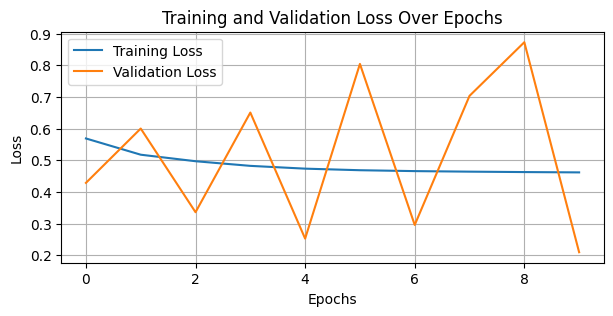

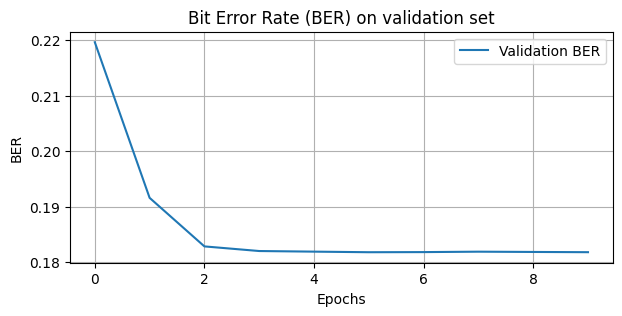

In [70]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="normalized_NAdam_scheduler_256n_val")
plot_val_BER(val_BERs, name="normalized_NAdam_scheduler_256n_BER")

**Comment**: BER looks similar but not as smooth. Validation curve, though, just jumps around non-stop. 128 seems like a sweet spot.


# Normalized model with more layers

## Layer1: 128, Layer2: 128

In [71]:
## 2 layers
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(in_features=128, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [72]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 339.66it/s]


Epoch [1/10], Loss: 0.4632, Val Loss: 0.8264, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 346.86it/s]


Epoch [2/10], Loss: 0.4576, Val Loss: 0.2150, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 348.58it/s]


Epoch [3/10], Loss: 0.4529, Val Loss: 0.7038, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 362.70it/s]


Epoch [4/10], Loss: 0.4492, Val Loss: 0.2080, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 359.67it/s]


Epoch [5/10], Loss: 0.4470, Val Loss: 0.1831, Val BER: 0.1816


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 360.57it/s]


Epoch [6/10], Loss: 0.4454, Val Loss: 0.2286, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 362.08it/s]


Epoch [7/10], Loss: 0.4439, Val Loss: 0.9054, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 370.11it/s]


Epoch [8/10], Loss: 0.4429, Val Loss: 0.7951, Val BER: 0.1821


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 366.76it/s]


Epoch [9/10], Loss: 0.4426, Val Loss: 0.7679, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 358.01it/s]


Epoch [10/10], Loss: 0.4418, Val Loss: 0.3551, Val BER: 0.1819


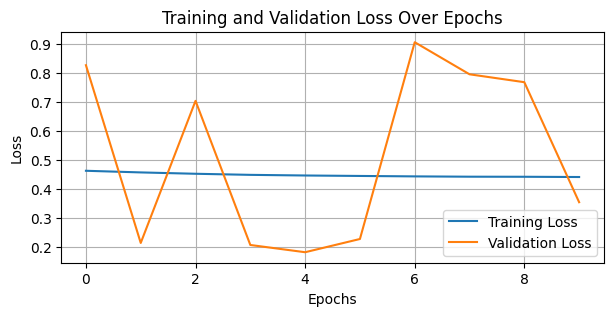

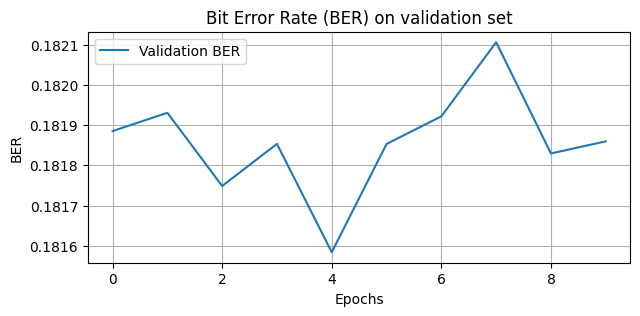

In [75]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="NAdam_128n_128n_val")
plot_val_BER(val_BERs, name="NAdam_128n_128n_BER")

**Comment**: It seems the model is a little too expressive. It's killing both the validation curve and BER curve.

## Layer 1 128, Layer 2 64

In [79]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(in_features=64, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [80]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 364.12it/s]


Epoch [1/10], Loss: 0.5830, Val Loss: 0.8247, Val BER: 0.1932


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 342.64it/s]


Epoch [2/10], Loss: 0.4790, Val Loss: 0.7665, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 367.27it/s]


Epoch [3/10], Loss: 0.4629, Val Loss: 0.8873, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 342.55it/s]


Epoch [4/10], Loss: 0.4590, Val Loss: 0.4028, Val BER: 0.1821


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 356.34it/s]


Epoch [5/10], Loss: 0.4552, Val Loss: 0.7470, Val BER: 0.1820


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 365.72it/s]


Epoch [6/10], Loss: 0.4528, Val Loss: 0.1902, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 349.00it/s]


Epoch [7/10], Loss: 0.4505, Val Loss: 0.1870, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 363.16it/s]


Epoch [8/10], Loss: 0.4482, Val Loss: 0.2476, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 359.92it/s]


Epoch [9/10], Loss: 0.4464, Val Loss: 0.3616, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 348.53it/s]


Epoch [10/10], Loss: 0.4454, Val Loss: 0.2056, Val BER: 0.1817


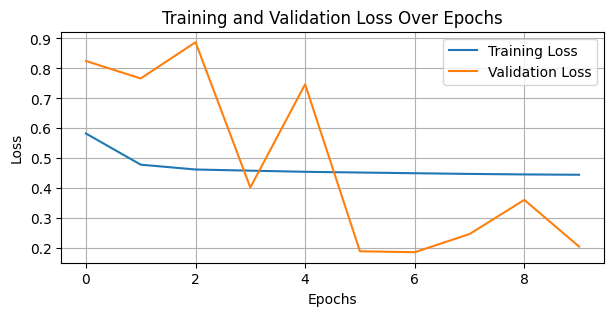

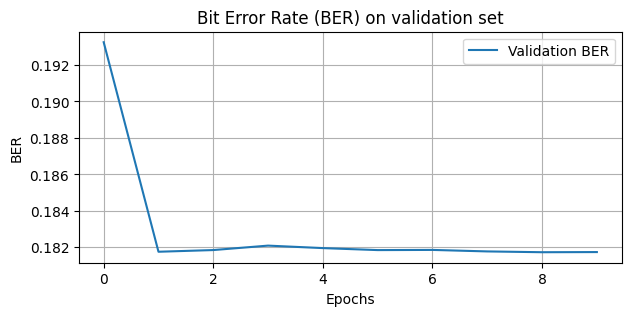

In [81]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="NAdam_128n_64n_val")
plot_val_BER(val_BERs, name="NAdam_128n_64n_BER")

**Comment**: The model still seems a little expressive. It hits the bottom as fast as possible then just stand there. 

Not to mention the fact that it's overfitting from epoch 1

## Layer1 64, Layer2 64

In [83]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(in_features=64, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [84]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 333.36it/s]


Epoch [1/10], Loss: 0.6060, Val Loss: 0.7141, Val BER: 0.2036


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 339.24it/s]


Epoch [2/10], Loss: 0.4939, Val Loss: 0.8619, Val BER: 0.1822


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 342.98it/s]


Epoch [3/10], Loss: 0.4681, Val Loss: 0.8424, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 347.23it/s]


Epoch [4/10], Loss: 0.4619, Val Loss: 0.8252, Val BER: 0.1820


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 332.43it/s]


Epoch [5/10], Loss: 0.4589, Val Loss: 0.8404, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 323.58it/s]


Epoch [6/10], Loss: 0.4570, Val Loss: 0.7107, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 343.34it/s]


Epoch [7/10], Loss: 0.4555, Val Loss: 0.1928, Val BER: 0.1821


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 327.71it/s]


Epoch [8/10], Loss: 0.4536, Val Loss: 0.3225, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 338.57it/s]


Epoch [9/10], Loss: 0.4521, Val Loss: 0.2023, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 333.83it/s]


Epoch [10/10], Loss: 0.4509, Val Loss: 0.4536, Val BER: 0.1818


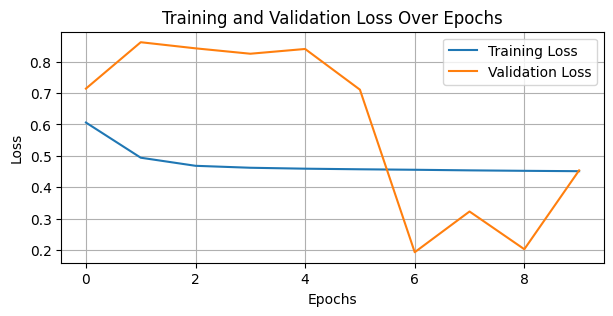

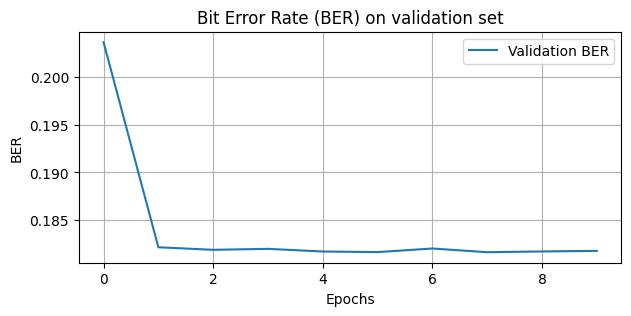

In [85]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="NAdam_64n_64n_val")
plot_val_BER(val_BERs, name="NAdam_64n_64n_BER")

**Comment**: Not much to say here except that the model is still a little too expressive.

## Layer1 64, Layer2 32

In [86]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(in_features=32, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [87]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 325.18it/s]


Epoch [1/10], Loss: 0.6341, Val Loss: 0.4699, Val BER: 0.2392


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 356.45it/s]


Epoch [2/10], Loss: 0.5172, Val Loss: 0.3240, Val BER: 0.1843


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 348.79it/s]


Epoch [3/10], Loss: 0.4778, Val Loss: 0.8526, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 326.54it/s]


Epoch [4/10], Loss: 0.4645, Val Loss: 0.2194, Val BER: 0.1821


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 322.90it/s]


Epoch [5/10], Loss: 0.4603, Val Loss: 0.2583, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 329.86it/s]


Epoch [6/10], Loss: 0.4583, Val Loss: 0.2317, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 335.65it/s]


Epoch [7/10], Loss: 0.4570, Val Loss: 0.7089, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 331.64it/s]


Epoch [8/10], Loss: 0.4560, Val Loss: 0.2265, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 338.48it/s]


Epoch [9/10], Loss: 0.4555, Val Loss: 0.1927, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 349.42it/s]


Epoch [10/10], Loss: 0.4546, Val Loss: 0.2305, Val BER: 0.1817


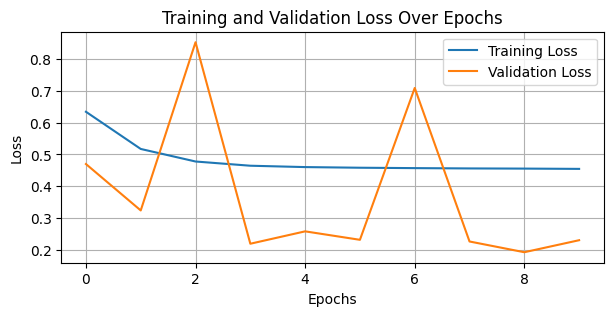

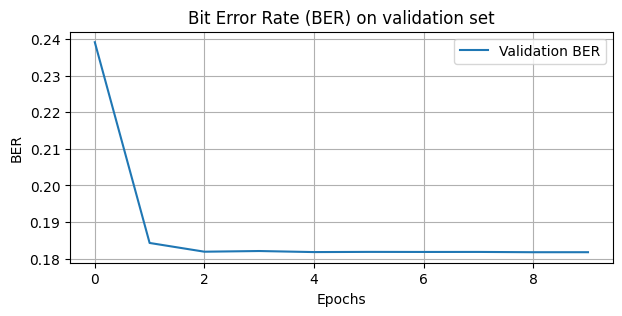

In [88]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="NAdam_64n_32n_val")
plot_val_BER(val_BERs, name="NAdam_64n_32n_BER")

**Comment** At least this model shows some sign of life with validation loss not jumping around all the place.

## Layer1 32 Layer2 32

In [89]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(in_features=32, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [90]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 346.14it/s]


Epoch [1/10], Loss: 0.6678, Val Loss: 0.6772, Val BER: 0.2744


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 332.84it/s]


Epoch [2/10], Loss: 0.5510, Val Loss: 0.5528, Val BER: 0.1863


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 352.31it/s]


Epoch [3/10], Loss: 0.4992, Val Loss: 0.5874, Val BER: 0.1827


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 321.31it/s]


Epoch [4/10], Loss: 0.4754, Val Loss: 0.3628, Val BER: 0.1822


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 331.53it/s]


Epoch [5/10], Loss: 0.4660, Val Loss: 0.4593, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 325.80it/s]


Epoch [6/10], Loss: 0.4623, Val Loss: 0.4958, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 341.34it/s]


Epoch [7/10], Loss: 0.4601, Val Loss: 0.8445, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 312.76it/s]


Epoch [8/10], Loss: 0.4585, Val Loss: 0.2037, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 325.42it/s]


Epoch [9/10], Loss: 0.4573, Val Loss: 0.4186, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 300.69it/s]


Epoch [10/10], Loss: 0.4562, Val Loss: 0.1956, Val BER: 0.1818


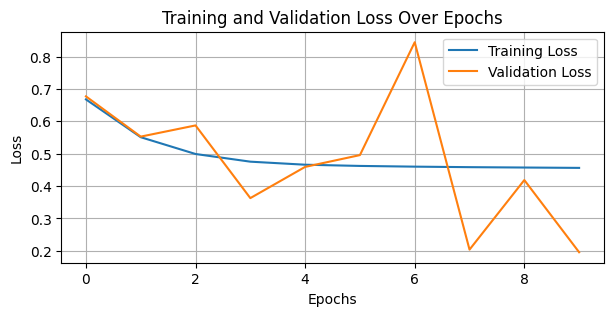

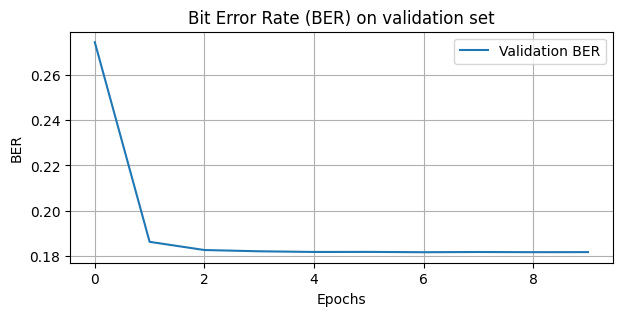

In [91]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="NAdam_32n_32n_val")
plot_val_BER(val_BERs, name="NAdam_32n_32n_BER")

**Comment** These curves are quite similar to the 2 layers 128 neurons model. 

We'll try one last thing: 16 neurons - 16 neurons - 4 

## Layer1 32, Layer2 16

In [94]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(in_features=16, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [95]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 358.05it/s]


Epoch [1/10], Loss: 0.6697, Val Loss: 0.6443, Val BER: 0.2821


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 328.10it/s]


Epoch [2/10], Loss: 0.5561, Val Loss: 0.3727, Val BER: 0.1839


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 317.10it/s]


Epoch [3/10], Loss: 0.4880, Val Loss: 0.3002, Val BER: 0.1820


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 341.91it/s]


Epoch [4/10], Loss: 0.4686, Val Loss: 0.4853, Val BER: 0.1819


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 335.05it/s]


Epoch [5/10], Loss: 0.4611, Val Loss: 0.3408, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 324.76it/s]


Epoch [6/10], Loss: 0.4585, Val Loss: 0.1937, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 334.70it/s]


Epoch [7/10], Loss: 0.4573, Val Loss: 0.3145, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 327.47it/s]


Epoch [8/10], Loss: 0.4564, Val Loss: 0.1939, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 335.54it/s]


Epoch [9/10], Loss: 0.4556, Val Loss: 0.3973, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 335.31it/s]


Epoch [10/10], Loss: 0.4551, Val Loss: 0.9293, Val BER: 0.1818


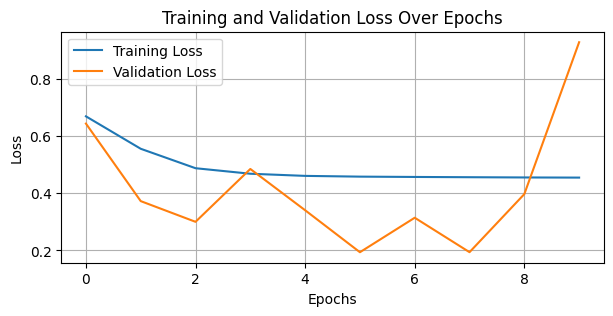

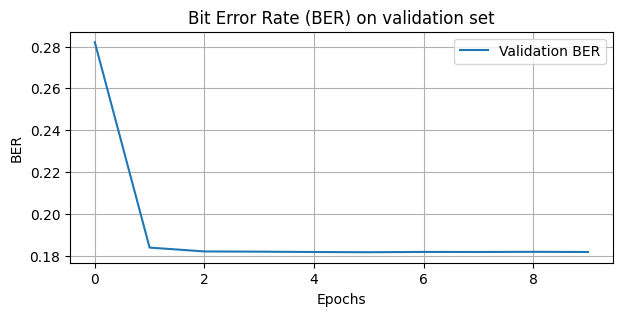

In [96]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="NAdam_32n_16n_val")
plot_val_BER(val_BERs, name="NAdam_32n_16n_BER")

**Comment**: Validation curve looks really good in this one.

**Conclusion so far**: 128 neurons 2 layers and 3 layers 32/16 perform quite well. The final chosen ones would be between those two.

# ConvNet

In [103]:
class SimpleConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = 8
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=6, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(6, 16, 3, padding='same')
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 4)
        self.activation = nn.ReLU()
        
    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 0, 2, 3) # batch channels x y
        z = torch.nn.functional.normalize(z)
        z = self.activation(self.conv1(z))
        z = self.activation(self.conv2(z))
        z = z.permute(0, 2, 3, 1)
        z = self.activation(self.fc1(z))
        z = self.fc2(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [104]:
# Create model
model = SimpleConv()

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 348.16it/s]


Epoch [1/10], Loss: 0.6050, Val Loss: 0.6978, Val BER: 0.2587


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 341.39it/s]


Epoch [2/10], Loss: 0.5313, Val Loss: 0.5084, Val BER: 0.2506


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 350.74it/s]


Epoch [3/10], Loss: 0.5236, Val Loss: 0.7978, Val BER: 0.2480


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 343.97it/s]


Epoch [4/10], Loss: 0.5200, Val Loss: 0.4899, Val BER: 0.2466


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 340.13it/s]


Epoch [5/10], Loss: 0.5182, Val Loss: 0.4204, Val BER: 0.2461


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 347.15it/s]


Epoch [6/10], Loss: 0.5164, Val Loss: 0.4162, Val BER: 0.2446


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 350.34it/s]


Epoch [7/10], Loss: 0.5158, Val Loss: 0.4493, Val BER: 0.2438


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 358.11it/s]


Epoch [8/10], Loss: 0.5150, Val Loss: 0.4399, Val BER: 0.2445


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 347.68it/s]


Epoch [9/10], Loss: 0.5142, Val Loss: 0.4904, Val BER: 0.2418


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 349.18it/s]


Epoch [10/10], Loss: 0.5139, Val Loss: 0.6785, Val BER: 0.2420


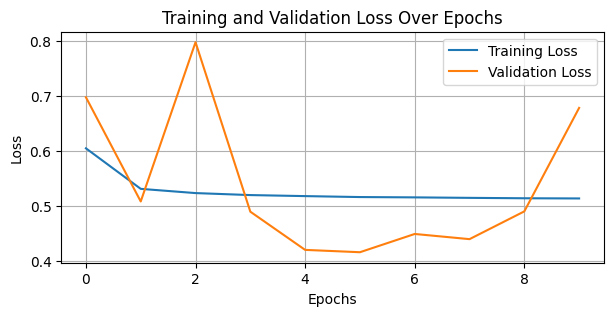

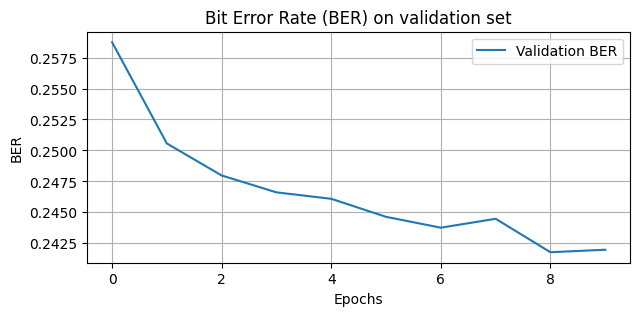

In [105]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="Conv_val")
plot_val_BER(val_BERs, name="Conv_BER")

**Comment**: Performance is worse than before. It's learning slower while overfitting from epoch 1.

It's better to stick with simpler models when performances are on par with each other.

# Best model with Dropout

Even though our previous results show that we don't really need dropout (our models are seemingly overfitting), we can just try adding drop out.

## Normalized 2 layers 128 neurons + Dropout

In [125]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=128)
        self.linear2=nn.Linear(in_features=128, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.dropout(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [126]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 222.80it/s]


Epoch [1/10], Loss: 0.6457, Val Loss: 0.5591, Val BER: 0.2356


100%|█████████████████████████████████████████████████████████████████████████████████| 640/640 [00:08<00:00, 77.41it/s]


Epoch [2/10], Loss: 0.5617, Val Loss: 0.7591, Val BER: 0.2193


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 216.61it/s]


Epoch [3/10], Loss: 0.5340, Val Loss: 0.4441, Val BER: 0.1968


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:03<00:00, 213.19it/s]


Epoch [4/10], Loss: 0.5185, Val Loss: 0.4561, Val BER: 0.1847


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:03<00:00, 211.60it/s]


Epoch [5/10], Loss: 0.5042, Val Loss: 0.5815, Val BER: 0.1820


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 298.66it/s]


Epoch [6/10], Loss: 0.4935, Val Loss: 0.5191, Val BER: 0.1818


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 362.18it/s]


Epoch [7/10], Loss: 0.4867, Val Loss: 0.2868, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 348.73it/s]


Epoch [8/10], Loss: 0.4827, Val Loss: 0.6369, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.76it/s]


Epoch [9/10], Loss: 0.4800, Val Loss: 0.2597, Val BER: 0.1817


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 378.30it/s]


Epoch [10/10], Loss: 0.4781, Val Loss: 0.7733, Val BER: 0.1817


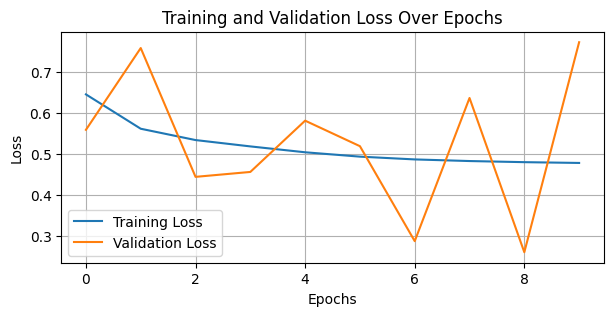

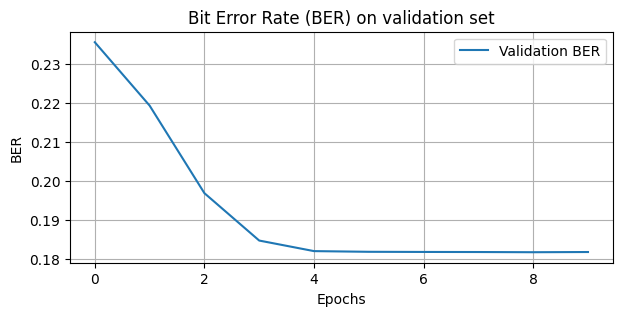

In [127]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="128n_dropout_train")
plot_val_BER(val_BERs, name="128n_dropout_BER")

**Comment**: validation curve jumps around but it doesn't jump too far from the base in-training error.

## 3 layer 32-16 with dropout

In [129]:
class NormalizedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(NormalizedModel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(in_features=16, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = torch.nn.functional.normalize(z)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.dropout(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.dropout(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [130]:
# Create model
model = NormalizedModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

# Setup loss + optimizer
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 350.64it/s]


Epoch [1/10], Loss: 0.6699, Val Loss: 0.6429, Val BER: 0.2846


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 337.60it/s]


Epoch [2/10], Loss: 0.5794, Val Loss: 0.6839, Val BER: 0.1904


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 353.14it/s]


Epoch [3/10], Loss: 0.5359, Val Loss: 0.4306, Val BER: 0.1899


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 381.85it/s]


Epoch [4/10], Loss: 0.5209, Val Loss: 0.6458, Val BER: 0.1867


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 355.12it/s]


Epoch [5/10], Loss: 0.5149, Val Loss: 0.3386, Val BER: 0.1853


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.49it/s]


Epoch [6/10], Loss: 0.5112, Val Loss: 0.3185, Val BER: 0.1840


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 363.55it/s]


Epoch [7/10], Loss: 0.5086, Val Loss: 0.6133, Val BER: 0.1836


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 346.62it/s]


Epoch [8/10], Loss: 0.5065, Val Loss: 0.8158, Val BER: 0.1829


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 334.46it/s]


Epoch [9/10], Loss: 0.5048, Val Loss: 0.6527, Val BER: 0.1826


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 366.40it/s]


Epoch [10/10], Loss: 0.5034, Val Loss: 0.2868, Val BER: 0.1827


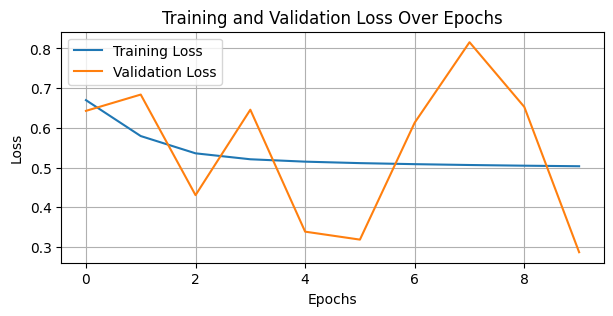

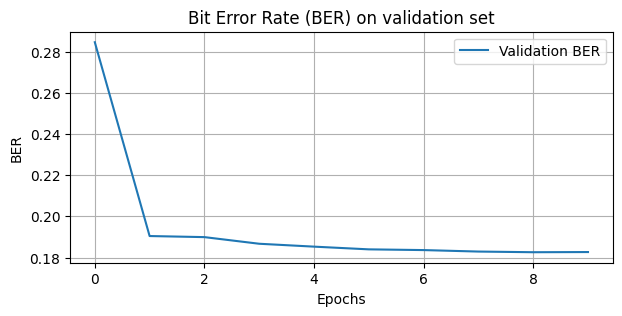

In [131]:
train_losses, val_losses, val_BERs, = training_loop(model, 0, 10, train_losses, val_losses, val_BERs, use_scheduler=True)

plot_train_val_loss(train_losses, val_losses, name="32n_16n_dropout_train")
plot_val_BER(val_BERs, name="32n_16n_dropout_BER")

**Comment** The model's performance is still unstable. Compare with the regular non-regualarized model, it still performs worse.

# Conclusion
The chosen model for this task would be:

- 3 layers with  2 - 32 - 16 - 4 neurons.

- NAdam optimizer

- ExponentialLR scheduler
